In [0]:
#settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#importing the necessary packages
from fastai.vision import *
from fastai.metrics import error_rate

#Looking at the data
We are going to use the [Oxford-IIIT Pet Dataset ](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [Omkar M Parkhi et al.,2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf).

In [3]:
#data
path = untar_data(URLs.PETS)
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations')]

In [4]:
path_img = path/'images'
path_anno = path/'annotations'
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/wheaten_terrier_147.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_pit_bull_terrier_202.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_115.jpg')]

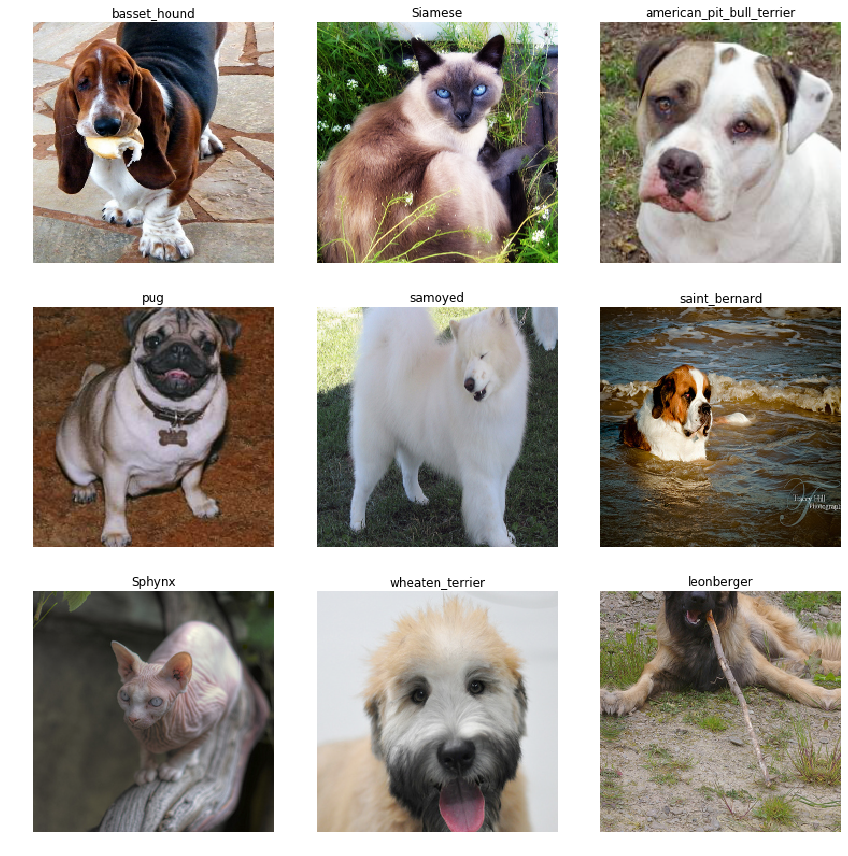

In [5]:
np.random.seed(66)
pat = r'/([^/]+)_\d+.jpg$'
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms = get_transforms(), size = 224, bs = 64).normalize(imagenet_stats)
data.show_batch(rows = 3)

In [6]:
print(data.classes)
print(len(data.classes))

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']
37


#Training: resnet34

In [7]:
learn = cnn_learner(data, models.resnet34, metrics = error_rate)
learn.model

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 95870935.19it/s]


Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [8]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.414713,0.362042,0.115020,01:18
1,0.547427,0.265857,0.083221,01:17
2,0.341744,0.242629,0.087280,01:17
3,0.255573,0.229548,0.079838,01:16


In [0]:
learn.save('stage-1')

#Results

In [0]:
interp = ClassificationInterpretation.from_learner(learn)


In [11]:
doc(interp.plot_top_losses)

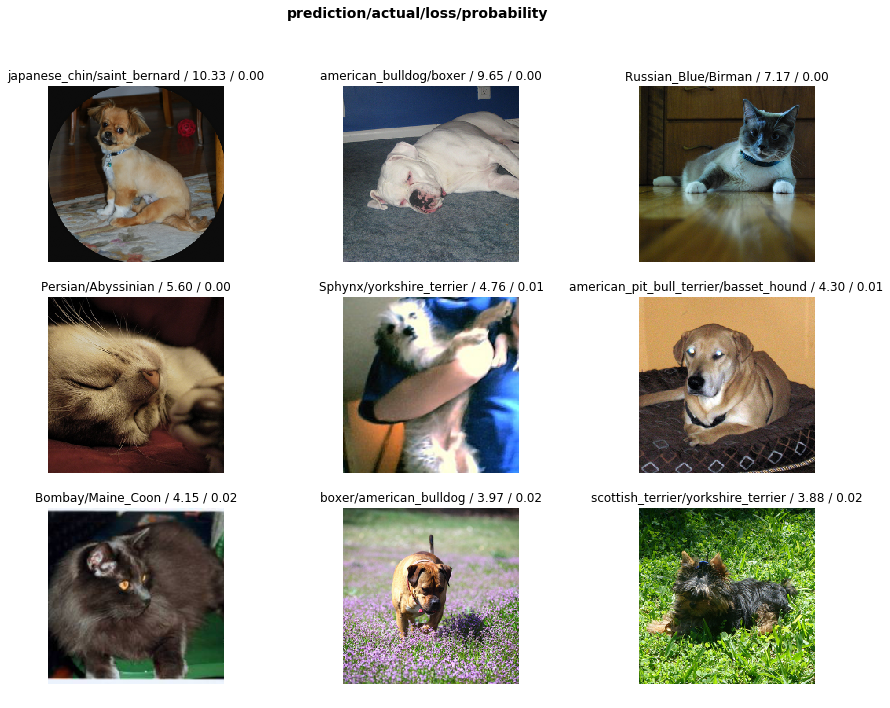

In [12]:
interp.plot_top_losses(9, heatmap=False, figsize=(15,11))

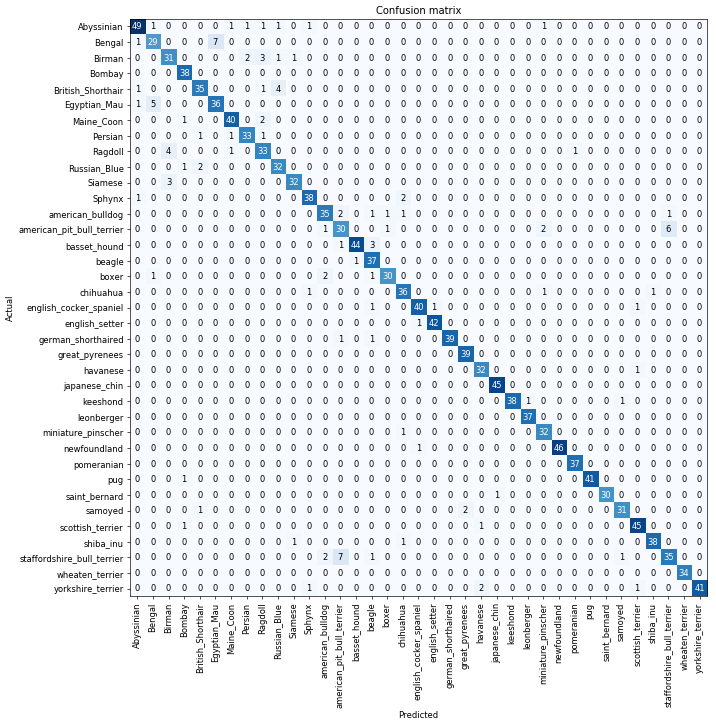

In [13]:
interp.plot_confusion_matrix(figsize = (12,12),dpi = 60)

In [14]:
interp.most_confused(min_val = 2)

[('Bengal', 'Egyptian_Mau', 7),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 7),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('British_Shorthair', 'Russian_Blue', 4),
 ('Ragdoll', 'Birman', 4),
 ('Birman', 'Ragdoll', 3),
 ('Siamese', 'Birman', 3),
 ('basset_hound', 'beagle', 3),
 ('Birman', 'Persian', 2),
 ('Maine_Coon', 'Ragdoll', 2),
 ('Russian_Blue', 'British_Shorthair', 2),
 ('Sphynx', 'chihuahua', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_pit_bull_terrier', 'miniature_pinscher', 2),
 ('boxer', 'american_bulldog', 2),
 ('samoyed', 'great_pyrenees', 2),
 ('staffordshire_bull_terrier', 'american_bulldog', 2),
 ('yorkshire_terrier', 'havanese', 2)]

#Fine-Tuning

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.534427,0.342072,0.102842,01:49


In [0]:
learn.load('stage-1');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


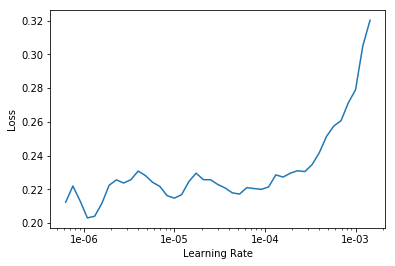

In [18]:
learn.lr_find();
learn.recorder.plot()

In [19]:
learn.unfreeze()
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.215656,0.219775,0.077808,01:20
1,0.204231,0.216897,0.078484,01:19


#Training: resnet50

In [20]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms = get_transforms(), size = 299, bs = 64//2).normalize(imagenet_stats)
learn = cnn_learner(data, models.resnet50, metrics = error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 94040942.90it/s]


In [0]:
help(learn.fit_one_cycle)

Help on method fit_one_cycle in module fastai.train:

fit_one_cycle(cyc_len:int, max_lr:Union[float, Collection[float], slice]=slice(None, 0.003, None), moms:Tuple[float, float]=(0.95, 0.85), div_factor:float=25.0, pct_start:float=0.3, final_div:float=None, wd:float=None, callbacks:Union[Collection[fastai.callback.Callback], NoneType]=None, tot_epochs:int=None, start_epoch:int=None) -> None method of fastai.basic_train.Learner instance
    Fit a model following the 1cycle policy.



LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


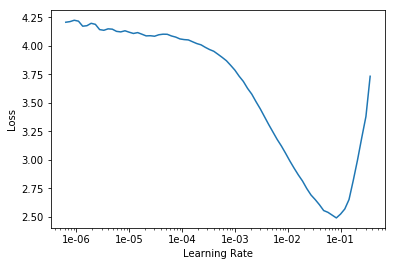

In [21]:
learn.lr_find()
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,0.747288,0.292995,0.091340,02:04
1,0.390006,0.297981,0.089310,02:00
2,0.358147,0.218715,0.075101,02:01
3,0.254770,0.225317,0.071719,02:00
4,0.208667,0.188809,0.060893,02:00
5,0.154101,0.181403,0.058187,02:00
6,0.115332,0.175561,0.056834,02:00
7,0.086177,0.175886,0.057510,02:00


In [0]:
learn.save('stage-1-50')

In [24]:
learn.unfreeze()
learn.fit_one_cycle(3,max_lr = slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.093524,0.174272,0.054804,02:12
1,0.108627,0.176009,0.055480,02:11
2,0.083271,0.174570,0.055480,02:11


In [0]:
learn.load('stage-1-50');

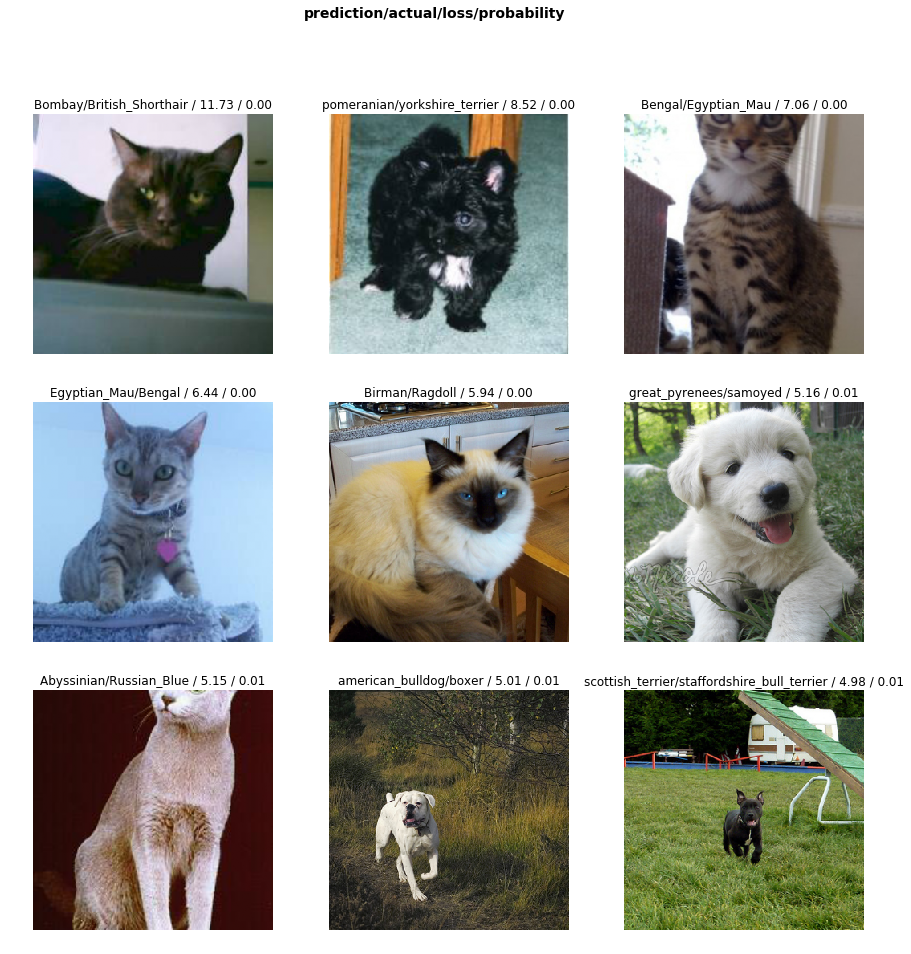

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, heatmap = False, figsize = (15,15))

In [27]:
interp.most_confused(min_val = 2)

[('american_pit_bull_terrier', 'staffordshire_bull_terrier', 6),
 ('Egyptian_Mau', 'Bengal', 5),
 ('staffordshire_bull_terrier', 'american_bulldog', 5),
 ('basset_hound', 'beagle', 4),
 ('Bengal', 'Egyptian_Mau', 3),
 ('Birman', 'Ragdoll', 3),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 3),
 ('Ragdoll', 'Birman', 2),
 ('Russian_Blue', 'Abyssinian', 2),
 ('american_bulldog', 'american_pit_bull_terrier', 2),
 ('american_pit_bull_terrier', 'american_bulldog', 2),
 ('beagle', 'basset_hound', 2),
 ('boxer', 'american_bulldog', 2),
 ('chihuahua', 'miniature_pinscher', 2),
 ('miniature_pinscher', 'chihuahua', 2),
 ('samoyed', 'great_pyrenees', 2),
 ('yorkshire_terrier', 'pomeranian', 2)]